colourmaps
https://www.pythonpool.com/matplotlib-cmap/#:~:text=%20Matplotlib%20cmap%20with%20its%20Implementation%20in%20Python,in%20lightness%20and%20possibly%20saturation%20of...%20More%20
plotting colour based on Z value
https://www.statology.org/matplotlib-scatterplot-color-by-value/#:~:text=The%20following%20code%20shows%20how%20to%20create%20a,plt%20%23create%20scatterplot%20plt.scatter%28df.x%2C%20df.y%2C%20s%3D200%2C%20c%3Ddf.z%2C%20cmap%3D%27gray%27%29

In [1]:
#load in data
import pandas as pd

#ground truth
gt_path = 'D:/datasets/soilHyperspec/train_data/train_data/train_gt.csv'

#MaskedTransformed data
mRx_path = r'C:\Users\oakle\OneDrive - University of Lincoln\uniProjects\soil\remote_sensing_hyperspectral_soil-main\remote_sensing_hyperspectral_soil-main\SVDmaskedRx.csv'


gt_df = pd.read_csv(gt_path)

mRx_df = pd.read_csv(mRx_path,header=None).values

# Treating datapoints as individual pixels

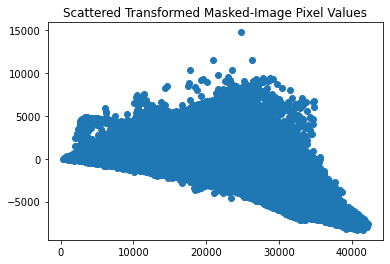

In [2]:
#Show transformed masked pixels vs unmasked pixels
import matplotlib.pyplot as plt
plt.figure()
plt.title("Scattered Transformed Masked-Image Pixel Values")
plt.scatter(mRx_df[:,0],mRx_df[:,1])

## Through indexing get according pixel dependant variables

In [3]:
#Get sizes of full images & masked images
import numpy as np
from tqdm.notebook import tqdm
import os

sizes = [] #index list for full image array (list of sizes for each image)
maskedIndexing = [] #index list for masked image array (list of unmasked-sizes for each image)

for file in tqdm(os.listdir('D:/datasets/soilHyperspec/train_data/train_data/train_data')):
    if file == '.DS_Store':
        continue
    with np.load('D:/datasets/soilHyperspec/train_data/train_data/train_data/' + file) as npz:
        arr = np.ma.MaskedArray(**npz)
        maskedIndexing.append(arr[0,:,:].count())
        sizes.append(arr.shape[1:3])
        del(arr)
        
sizeIndexing = [i[0]*i[1] for i in sizes]

  0%|          | 0/1733 [00:00<?, ?it/s]

In [4]:
#adds corresponding pixel 'y' values to dataframe
def expandDataframe(svdDF, GT_DATAFRAME, indexing):
    pH = list(GT_DATAFRAME['pH'].values)
    P = list(GT_DATAFRAME['P'].values)
    K = list(GT_DATAFRAME['K'].values)
    Mg = list(GT_DATAFRAME['Mg'].values)
    
    pHExpanded = []
    PExpanded = []
    KExpanded = []
    MgExpanded = []
    
    for i in range(0,len(indexing)): #[121,...]
        for j in range(0,indexing[i]):#[0,1,...,121]
            #add pH value to list
            pHExpanded.append(pH[i])
            PExpanded.append(P[i])
            KExpanded.append(K[i])
            MgExpanded.append(Mg[i])
        
    #add extra column to dataframe
    expandedDF = pd.DataFrame({'SVD1':svdDF[:,0],
                              'SVD2':svdDF[:,1],
                              'pH': pHExpanded,
                              'P': PExpanded,
                              'K': KExpanded,
                              'Mg': MgExpanded})
    
    return expandedDF

## Masked Image Pixels

In [5]:
maskedExpandedDF = expandDataframe(mRx_df, gt_df,maskedIndexing)

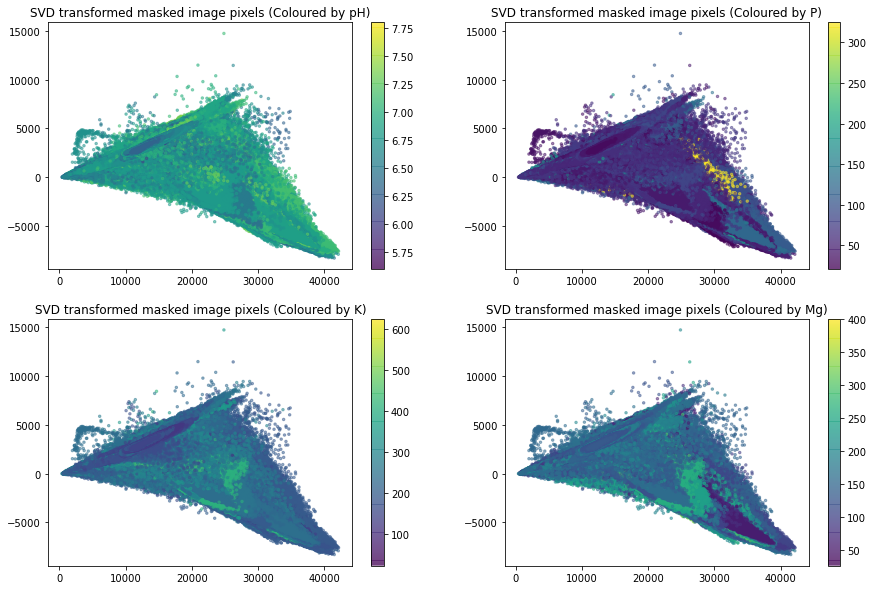

In [6]:
depVars = ['pH', 'P' , 'K', 'Mg']
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(maskedExpandedDF['SVD1'], maskedExpandedDF['SVD2'], s = 6, c=maskedExpandedDF[depVars[i]], alpha = 0.5, cmap='viridis')
    plt.title(f"SVD transformed masked image pixels (Coloured by {depVars[i]})")
    plt.colorbar()

# Treating datapoints as Images (Averaged SVD1 & SVD2 Value)

In [7]:
#get average/median SVD1 & SVD2 per image
from statistics import mean, median

def centralSVDs(svdDF,indexing, measure = 'mean'):
    pooledSVD1 = []
    pooledSVD2 = []

    pixelsSeen = 0 #aids in indexing(cuts off values already averaged and added to list) 

    #loop through indexing
    for i in tqdm(range(0,len(indexing))):
        ind = indexing[i] # save index
        maxIndex = pixelsSeen + ind #create start and end index values to loop through 
        minIndex = pixelsSeen
        svd1 = []
        svd2 = []
        for j in range(minIndex,maxIndex): # loops through defined index values
            svd1.append(svdDF[:,0][j])
            svd2.append(svdDF[:,1][j])
        
        if measure == 'mean':
            #get average
            pooledSVD1.append(mean(svd1))
            pooledSVD2.append(mean(svd2))
        if measure == 'median':
            #get median
            pooledSVD1.append(median(svd1))
            pooledSVD2.append(median(svd2))
            
            
        pixelsSeen += ind #move along pixels to next 'image' bunch
    
    return pooledSVD1, pooledSVD2

# Masked Images

In [8]:
maAvgSVD1, maAvgSVD2 = centralSVDs(mRx_df,maskedIndexing)

  0%|          | 0/1732 [00:00<?, ?it/s]

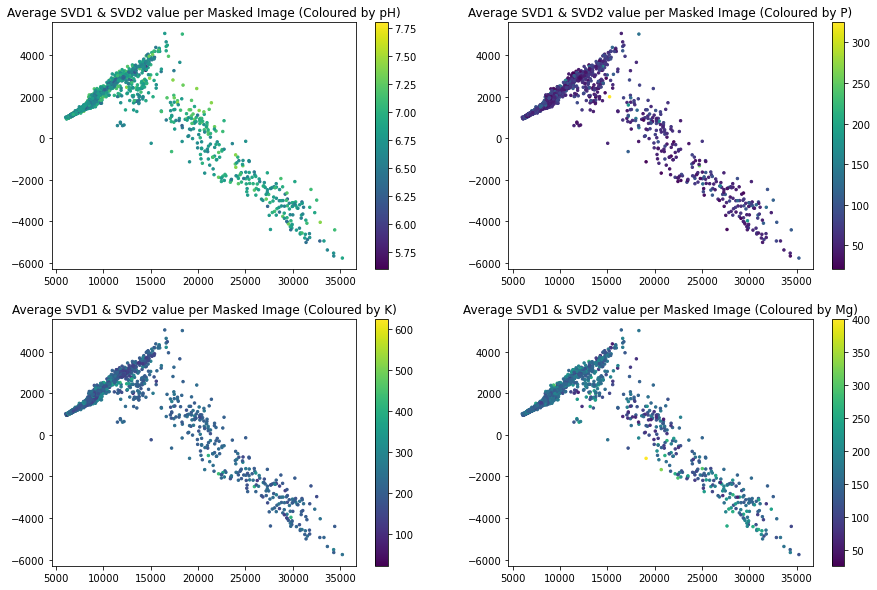

In [9]:
#plot average SVD value(s) for each image
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(maAvgSVD1, maAvgSVD2, s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.title(f"Average SVD1 & SVD2 value per Masked Image (Coloured by {depVars[i]})")
    plt.colorbar()
    
    #histogram of ground truth values (dataset notebook, np.hist)

In [10]:
medAvgSVD1, medAvgSVD2 = centralSVDs(mRx_df,maskedIndexing,'median')

  0%|          | 0/1732 [00:00<?, ?it/s]

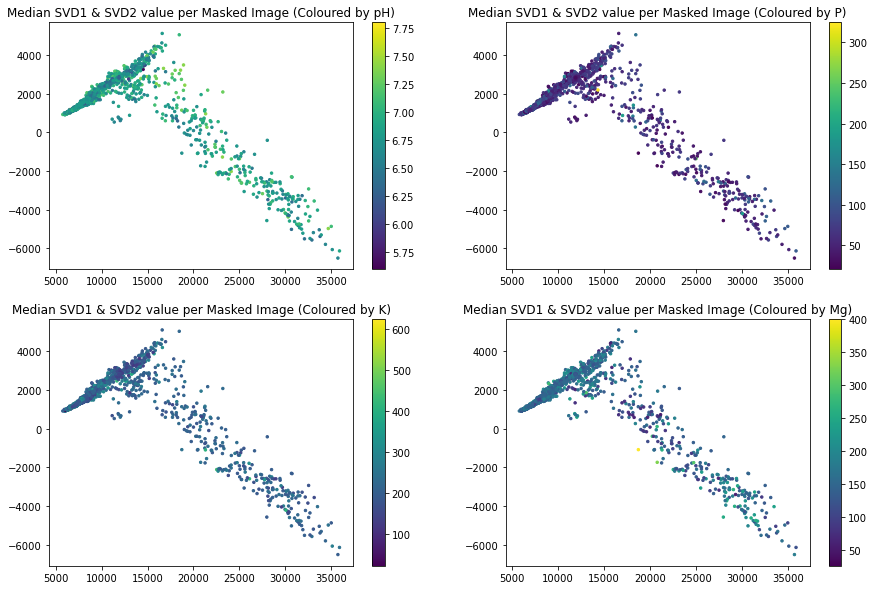

In [11]:
#plot median SVD value(s) for each image
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(medAvgSVD1, medAvgSVD2, s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.title(f"Median SVD1 & SVD2 value per Masked Image (Coloured by {depVars[i]})")
    plt.colorbar()

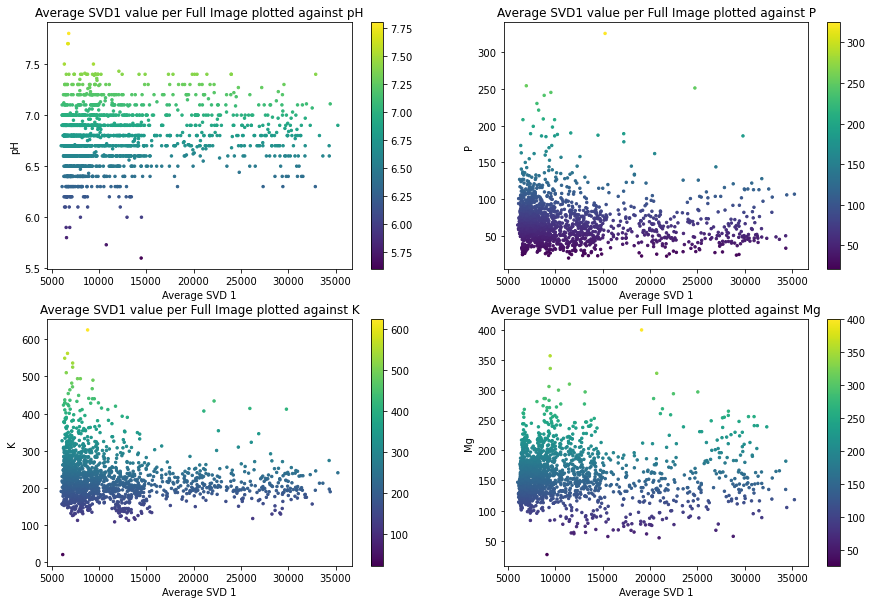

In [12]:
#Plot first SVD value against variables (holds highest variance)
plt.figure(figsize=(15, 10))
for i in range(0, len(depVars)):
    plt.subplot(2, 2, i+1)
    plt.scatter(maAvgSVD1, gt_df[depVars[i]], s = 6, c=gt_df[depVars[i]], cmap='viridis')
    plt.xlabel('Average SVD 1')
    plt.ylabel(depVars[i])
    plt.title(f"Average SVD1 value per Full Image plotted against {depVars[i]}")
    plt.colorbar()

## Download AverageSVD1 and AverageSVD2 values

In [13]:
from numpy import savetxt
averagedDF = pd.DataFrame({'avSVD1':maAvgSVD1,
                              'avSVD2':maAvgSVD2})
savetxt('mAveragedSVD.csv', averagedDF, delimiter=',')